In [40]:
import os
import cv2
import shutil
import PIL
import random
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [48]:
# LOCAL VARIABLES
BASE_DIR = '../../dataset/'
SAVED_MODEL_DIR = BASE_DIR + '../model'

In [41]:
DATASET_DIR = BASE_DIR + 'final_dataset/'
DATA_DIR = Path(DATASET_DIR)
IMG_HEIGHT = 256
IMG_WIDTH = 256

In [42]:
EPOCHS = 10
BATCH_SIZE = 64

In [43]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    batch_size = BATCH_SIZE,
    image_size = (IMG_HEIGHT, IMG_WIDTH),
    validation_split = 0.2,
    seed = 123,
    subset = 'training')

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    seed = 123,
    batch_size = BATCH_SIZE,
    image_size = (IMG_HEIGHT, IMG_WIDTH),
    validation_split = 0.2,
    subset = "validation"
)
class_names = train_ds.class_names
print(class_names)

Found 17066 files belonging to 3 classes.
Using 13653 files for training.
Found 17066 files belonging to 3 classes.
Using 3413 files for validation.
['correctly-masked', 'not-masked', 'uncorrectly-masked']


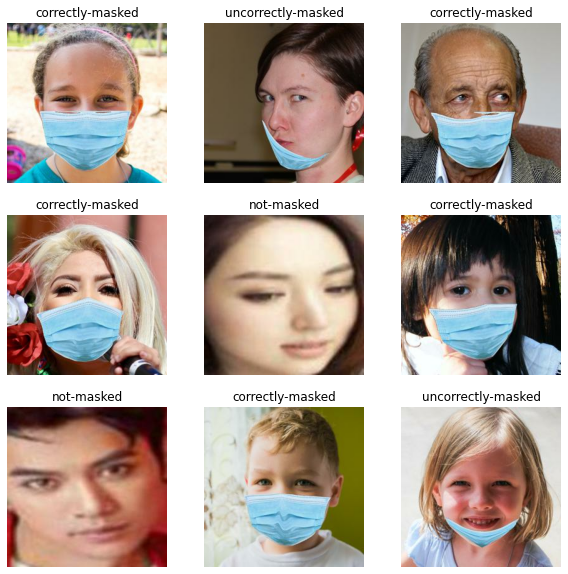

In [44]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(random.randint(1, 100)):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(IMG_HEIGHT, 
                                                              IMG_WIDTH,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [45]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [46]:
num_classes = len(class_names)

model = Sequential([
  #data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  #layers.Conv2D(32, 3, padding='same', activation='relu'),
  #layers.MaxPooling2D(),
  #layers.Conv2D(64, 3, padding='same', activation='relu'),
  #layers.MaxPooling2D(), 
  #layers.Conv2D(128, 3, padding='same', activation='relu'),
  #layers.MaxPooling2D(),
  #layers.Dropout(0.2),
  layers.Flatten(),
  #layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

#hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
#model.compile(loss = 'categorical_crossentropy',
#                optimizer = tf.keras.optimizers.RMSprop(learning_rate=hp_learning_rate),
#                metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
flatten (Flatten)            (None, 262144)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                16777280  
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 16,777,923
Trainable params: 16,777,923
Non-trainable params: 0
____________________________________________

In [47]:
start_time = time.time()
epochs = EPOCHS
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)
model.save(SAVED_MODEL_DIR)
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/10
214/214 [==============================] - 262s 1s/step - loss: 1.0091 - accuracy: 0.8908 - val_loss: 0.0576 - val_accuracy: 0.9830
Epoch 2/10
214/214 [==============================] - 333s 2s/step - loss: 0.0364 - accuracy: 0.9905 - val_loss: 0.0270 - val_accuracy: 0.9912
Epoch 3/10
214/214 [==============================] - 335s 2s/step - loss: 0.0135 - accuracy: 0.9969 - val_loss: 0.0261 - val_accuracy: 0.9909
Epoch 4/10
214/214 [==============================] - 297s 1s/step - loss: 0.0062 - accuracy: 0.9988 - val_loss: 0.0230 - val_accuracy: 0.9930
Epoch 5/10
214/214 [==============================] - 289s 1s/step - loss: 0.0052 - accuracy: 0.9988 - val_loss: 0.0192 - val_accuracy: 0.9944
Epoch 6/10
214/214 [==============================] - 347s 2s/step - loss: 0.0051 - accuracy: 0.9989 - val_loss: 0.0178 - val_accuracy: 0.9947
Epoch 7/10
214/214 [==============================] - 342s 2s/step - loss: 0.0041 - accuracy: 0.9987 - val_loss: 0.0261 - val_accuracy: 0.9924

In [50]:
model = keras.models.load_model(SAVED_MODEL_DIR)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
flatten (Flatten)            (None, 262144)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                16777280  
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 16,777,923
Trainable params: 16,777,923
Non-trainable params: 0
____________________________________________

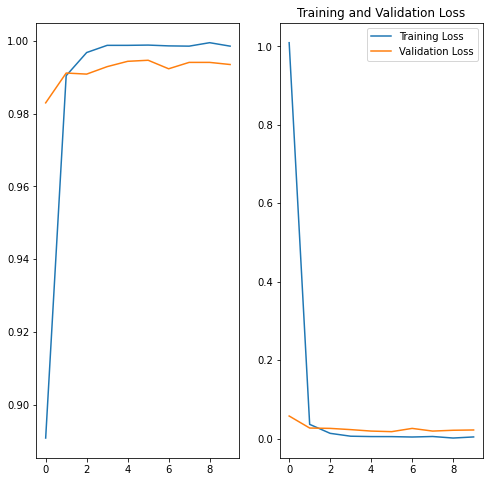

In [51]:
acc = history.history['accuracy']
loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
img_url = "https://cdn.shopify.com/s/files/1/0281/7544/products/TecaCottonMask-FacialExpressions-078_700x.jpg?v=1605320235"
img_path = tf.keras.utils.get_file(f'{random.randint(0, 100000)}', origin=img_url)

img = keras.preprocessing.image.load_img(
    img_path, target_size=(IMG_HEIGHT, IMG_WIDTH)
)
_ = plt.imshow(img)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)